# Day 25 - finding disconnected subgraphs

* [Day 25](https://adventofcode.com/2018/day/25)

We are asked to see fixed points in 4 dimensions as connected, if they are a Manhattan distance of 3 or less apart.

We once again can reach to the [`scipy.spacial.distance` package](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) to do the Manhattan distance calculations for all our points in one step (we used this same package for the [day 6 solution](./Day%2006.ipynb)). The [`pdist()` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) gives us all the pair-wise distances; the first n - 1 rows are the distances between the first point and every other point, followed by n - 2 rows of distances between the second point and the remaining points following, etc. Those distances are trivially turned into a boolean sequence to mark points as 'near'.

What remains is to record this information in a dictionary as an undirected graph, and then count the subgraphs (constellations) by traversing the graphs until you run out of nodes, then moving on to the next unvisited node.

In [1]:
from collections import deque
from itertools import combinations
from typing import Iterable, Mapping

import numpy as np
from scipy.spatial import distance

def load_points(data: Iterable[str]):
    return np.loadtxt(data, dtype=np.int8, delimiter=',')

def points_to_graph(points) -> Mapping[int, int]:
    """Produce a dictionary of connected edges in an undirected graph"""
    indices = range(points.shape[0])
    # A matrix containing len(points) * (len(points) - 1) // 2 boolean flags
    # giving us half of a square proximity matrix (first n - 1 entries are for
    # the 0th point against the other points, the next n - 2 entries are for
    # the 1st point against the remainder, etc.)
    near = distance.pdist(points, 'cityblock') <= 3
    # combinations(len(points), 2) produces the matching indices back into
    # points for those booleans, which we can then filter on.
    connected = (combo for combo, is_near in zip(combinations(indices, 2), near) if is_near)
    # mapping from point index to connected point indices in a graph
    # both directions are represented, all points are represented (even
    # if the points are not connected to anything else).
    graph = {i: set() for i in indices}
    for i, j in connected:
        graph[i].add(j)
        graph[j].add(i)
    return graph

def count_subgraphs(graph: Mapping[int, int]):
    # traverse the graph from an arbitrary node, removing nodes
    # we visit. When we run out of nodes to visit, we cleared one
    # graph, and can jump to the next arbitrary node.
    nodes = set(graph)
    graphs = 0
    while nodes:
        graphs += 1
        queue = deque([nodes.pop()])
        while queue:
            node = queue.pop()
            for next_ in graph[node]:
                if next_ not in nodes:
                    continue
                nodes.remove(next_)
                queue.append(next_)
    return graphs

In [2]:
tests = {
    '0,0,0,0\n3,0,0,0\n0,3,0,0\n0,0,3,0\n0,0,0,3\n0,0,0,6\n9,0,0,0\n12,0,0,0': 2,
    '-1,2,2,0\n0,0,2,-2\n0,0,0,-2\n-1,2,0,0\n-2,-2,-2,2\n3,0,2,-1\n-1,3,2,2\n-1,0,-1,0\n0,2,1,-2\n3,0,0,0': 4,
    '1,-1,0,1\n2,0,-1,0\n3,2,-1,0\n0,0,3,1\n0,0,-1,-1\n2,3,-2,0\n-2,2,0,0\n2,-2,0,-1\n1,-1,0,-1\n3,2,0,2': 3,
    '1,-1,-1,-2\n-2,-2,0,1\n0,2,1,3\n-2,3,-2,1\n0,2,3,-2\n-1,-1,1,-2\n0,-2,-1,0\n-2,2,3,-1\n1,2,2,0\n-1,-2,0,-2': 8,
}
for test, expected in tests.items():
    assert count_subgraphs(points_to_graph(load_points(test.splitlines()))) == expected

In [3]:
import aocd

data = aocd.get_data(day=25, year=2018)
fixed_points = load_points(data.splitlines())
graph = points_to_graph(fixed_points)
print('Part 1:', count_subgraphs(graph))

Part 1: 399


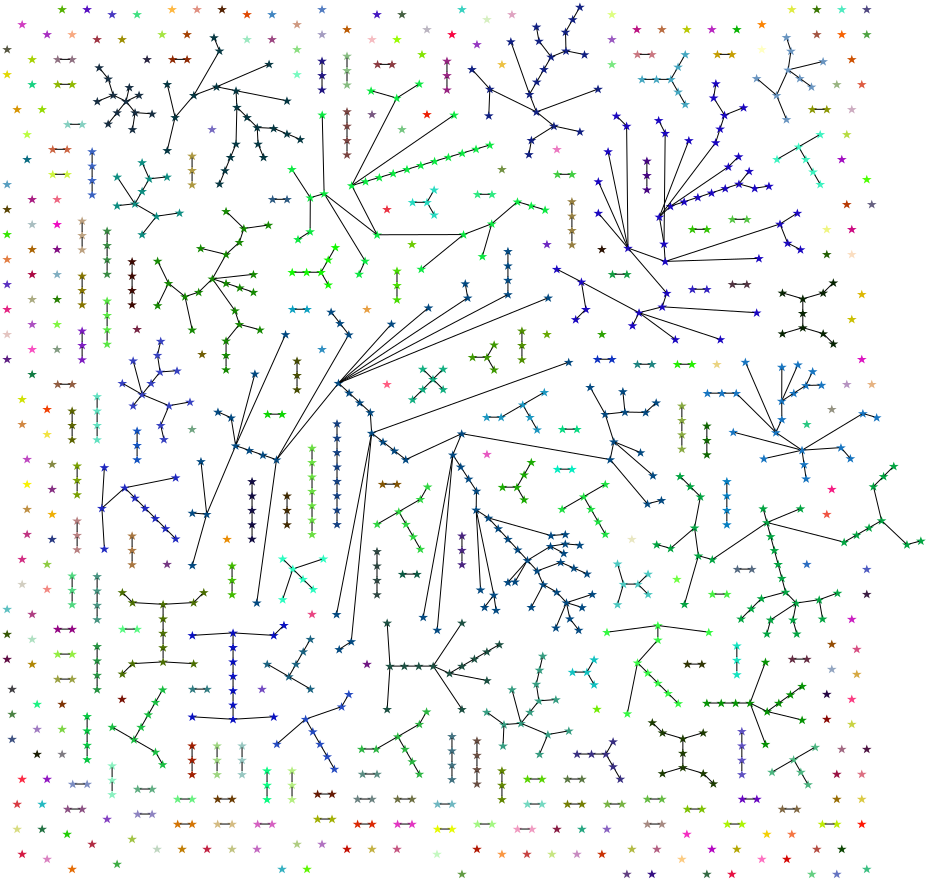

In [4]:
from graphviz import Graph

def render_graphs(points):
    g = Graph('Fixed points', engine='twopi')
    g.attr(nodesep='0.02', ranksep='0.2')
    g.attr('node', shape='star', margin='0', width='0.08', height='0.08', style='filled')
    graph = points_to_graph(points)
    count = count_subgraphs(graph)
    nodes = set(graph)
    c = 0
    while nodes:
        with g.subgraph() as sg:
            c += 0xFFFFFF // count
            sg.attr('node', color=f'#{c:06x}', fillcolor=f'#{c:06x}')
            start = min(nodes)
            queue = deque([start])
            nodes.remove(start)
            while queue:
                node = queue.pop()
                sg.node(str(node), '')
                for next_ in sorted(graph[node]):
                    if next_ not in nodes:
                        continue
                    nodes.remove(next_)
                    queue.append(next_)
                    sg.edge(str(node), str(next_))        
    return g

render_graphs(fixed_points)

## Part 2 - Merry Christmas!

As is traditional, the 50th star is handed to you as a Christmas gift. :-)